<a href="https://colab.research.google.com/github/dillanhoyos/Cl/blob/New-Branch/Copy_of_09_skimlit_nlp_milestone_project_2_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLlit
The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.
The paper were replicating(the source of the dataset that well be using is available here: https://arxiv.org/pdf/1710.06071.pdf)\

And reading through the paper above we see that the model architure that they use to achieve their best reuslt si is available herE:

*Resource* if you wat to find the ground truth for this note book(with lots of diagrams and text anothations see the Github)

Confirm acces toGPU

In [ ]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


#Get data
Since well be replicating the paper above (pubmed 200k RCT)

We can do so from the authors Github:


In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 4.80 MiB/s, done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
#Check what file sare in the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/


dev.txt  test.txt  train.txt


In [ ]:
#Start our experiments using the 20k dataset with numbers replaceed by "@" sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
data_dir



'/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [ ]:
#Chek all of the filenames in the target directory
import os
filenames= [ data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

##Preprocess data
Now we've got some text data, its time to become on with it .
And one of the best ways to become one with tdata is to.....

> VIsualize, Visualize, Visualize

So with that in mind, lets write a function to read inall of the line sof a target text file.

In [ ]:
# Create function to read the lines of a document

def get_lines(filename):
  """
  Read filename (a text filename ) and return the lines of text as a list.

  Args:
    filanme: a string containing the target filepath.

  Returns:
    A list of string with one string per line form the target filename.
  """

  with open(filename, "r") as f:
    return f.readlines()



In [ ]:
# Lets read in the trining lines
train_lines = get_lines(data_dir+"train.txt")
train_lines[:3]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n']

In [ ]:
len(train_lines)

210040

Lets think about how we want our data to look

How I think our data would be best represented ....
```
[{'line_number`: 0,
  `target`: Background,
  `text`: Emotional eating is associated with overeating and the development of obesity,
  `total_lines: 11}]

  ```

In [ ]:

for i, lines in enumerate(train_lines[:10]):

  Target = lines.split()[0]
  Text = lines

  # Text = lines.join(Target[1:])
  print(f"LineNumber{i}")
  print(f"Target: {Target}")
  print(f"Text {Text}")




LineNumber0
Target: ###24293578
Text ###24293578

LineNumber1
Target: OBJECTIVE
Text OBJECTIVE	To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .

LineNumber2
Target: METHODS
Text METHODS	A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .

LineNumber3
Target: METHODS
Text METHODS	Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .

LineNumber4
Target: METHODS
Text METHODS	Pain was assessed using the visual analog pain scale ( @-@ mm ) .

LineNumber5
Target: METHODS
Text METHODS	Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment (

In [ ]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionarie sof abstract line data.

  Takes in filename, read it contents and sort through each line,
  extracting things like the target labels, the text of the sentences
  how many sentences are in the current abstract and what sentence number the target line is.
  """

  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empy list of abstract

  #loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): #Check to see if the is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the lines is an ID line
    elif line.isspace(): #Check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines()#split abstract into separate lines

      #Iterate through each line ina single abstract and count htem at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} #Create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") #split target label for text
        line_data["target"] = target_text_split[0] #get target label
        line_data["text"] = target_text_split[1].lower() #get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 #How many total lines are the in the target abstract?(start)

        abstract_samples.append(line_data) #add line data to abstract samples list

    else:# if the above conditions arent fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples


In [ ]:
#Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir +"dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir +"test.txt")

val_samples[1]
len(train_samples), len(val_samples), len(test_samples)


CPU times: user 705 ms, sys: 142 ms, total: 847 ms
Wall time: 1.65 s


(180040, 30212, 30135)

In [ ]:
#Check the first abstract of our training data
val_samples[:10]

[{'target': 'BACKGROUND',
  'text': 'ige sensitization to aspergillus fumigatus and a positive sputum fungal culture result are common in patients with refractory asthma .',
  'line_number': 0,
  'total_lines': 9},
 {'target': 'BACKGROUND',
  'text': 'it is not clear whether these patients would benefit from antifungal treatment .',
  'line_number': 1,
  'total_lines': 9},
 {'target': 'OBJECTIVE',
  'text': 'we sought to determine whether a @-month course of voriconazole improved asthma-related outcomes in patients with asthma who are ige sensitized to a fumigatus .',
  'line_number': 2,
  'total_lines': 9},
 {'target': 'METHODS',
  'text': 'asthmatic patients who were ige sensitized to a fumigatus with a history of at least @ severe exacerbations in the previous @ months were treated for @ months with @ mg of voriconazole twice daily , followed by observation for @ months , in a double-blind , placebo-controlled , randomized design .',
  'line_number': 3,
  'total_lines': 9},
 {'targe

Now that our data is the format of a list of dictionaries, how about we tuen it into a Dataframe to further visualize it.

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [ ]:
#Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

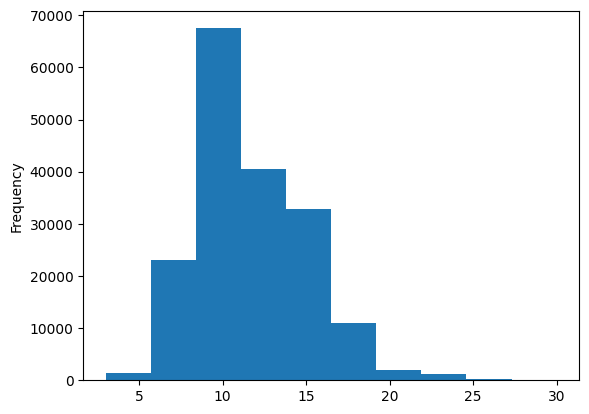

In [ ]:
#Lets check the length of differnet lines
train_df.total_lines.plot.hist()

### Get list of sentences


In [ ]:
#Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)


(180040, 30212, 30135)

In [ ]:
#VIew the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Make numberic labels (ML Models require numeric labels)

In [ ]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False) #we want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1,1))


#Check what one hot encoded labels look like
train_labels_one_hot
val_labels_one_hot
test_labels_one_hot


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

In [ ]:
import tensorflow as tf
tf.constant(train_labels_one_hot)

<tf.Tensor: shape=(180040, 5), dtype=float64, numpy=
array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])>

Label encode labels"


In [ ]:
#Extract Labels ("target columns") and encode the into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

#Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
#Get class names and number of classes form labelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modellin experiments..

As usual, were going to be trying out a bunch of different models and seeing which one works best.
And as always, were going to start with a baseline(TF-IDF Multinomial Naive Bayes classifier)


In [ ]:
## Model 0: Getting a baseline

from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

#Fit the pipeline to the traiing data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

train_sentences[1]



'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .'

In [ ]:
#Evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [ ]:
#Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds


array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

### Download helper function script

In the previous modeule, we wrote a function to compare predictions across different metrics(accuracy, precision, recal and f1) and rather than rewriting it here, lets download it here
https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-06-19 01:35:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-19 01:35:27 (86.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)

baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Preparing our text to be in text tokens and then embeddings for deep sequence model

Before we start building deeper models, weve go to create vectorization and embdedding layers


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers


In [ ]:
#How long is each sentence on averagese
sent_lens = [len(sentence.split()) for sentence in train_sentences]

In [ ]:
#How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

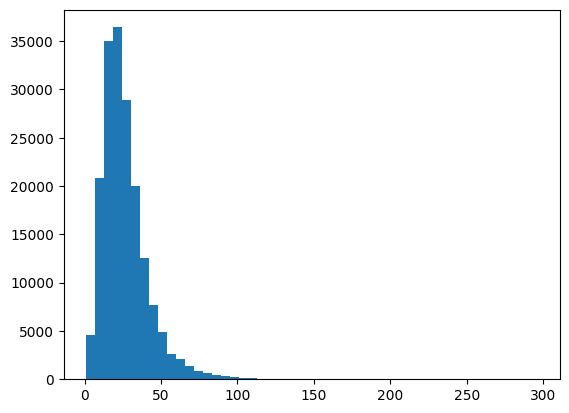

In [ ]:
# whats the distribution look like?

import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=50);

In [ ]:
# How long of a sentences length covers95% of examples?
output_seq_len = int(np.percentile(sent_lens,95))
output_seq_len

55

In [ ]:
#Maximmum sequence length in the training set
max(sent_lens)

296

### Create text vecotrizer layer
We want to make a layer which turns our texts from words to numbers.


In [ ]:
#How many words ar ein our vocab? (taken from table 2 in )

max_tokens=68000


In [ ]:
#Create text Vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # Number of vocabulary
                                    output_sequence_length=output_seq_len) #desired output lenght of vectorization




In [ ]:
#Adapt text vectoizer to training sentences
text_vectorizer.adapt(train_sentences)

In [ ]:
# test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: { len(target_sentence)}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
adjuvant denosumab @ mg twice per year reduces the risk of clinical fractures in postmenopausal women with breast cancer receiving aromatase inhibitors , and can be administered without added toxicity .

Length of text: 202

Vectorized text: [[1071 3513   68  555  160  157  827    2   73    4   47 1285    5 1460
    90    7  413  135  245 7406 1374    3  171   36  336  159 1192  997
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [ ]:
# How many words in our training vocabulary rc
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab:{len(rct_20k_text_vocab)}")
print(f"Most Common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least commons words in the vocab:{rct_20k_text_vocab[-5:]}")

Number of words in vocab:64841
Most Common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least commons words in the vocab:['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding

In [ ]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128, # Note: different embedding sizes result in drastically different number of parameters to train
                               mask_zero=True, #use masking to handle variable sequence lengths(Save space),
                               name="token_embedding")

In [ ]:
#Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 adjuvant denosumab @ mg twice per year reduces the risk of clinical fractures in postmenopausal women with breast cancer receiving aromatase inhibitors , and can be administered without added toxicity .

Sentence after vectorization (before embedding):
 [[1071 3513   68  555  160  157  827    2   73    4   47 1285    5 1460
    90    7  413  135  245 7406 1374    3  171   36  336  159 1192  997
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[ 0.03079143 -0.02669473 -0.04869472 ...  0.01216676 -0.04630432
   -0.01866416]
  [-0.00551766  0.02039656 -0.00715766 ... -0.04320982  0.0267233
   -0.04359375]
  [-0.02076845  0.03345677 -0.03445869 ... -0.0197966  -0.00829444
    0.03853988]
  ...
  [-0.04232973 -0.01915937 -0.0154619  ...  0.00194473 -0.02878263
    0.01757256]
  [-0.04232973 -0.01915937 -0.0154619  ...  0.00194473 -0.028782

## Creating datasets(making sure our data loads as fast as posible)

We're going to setup our data to run as fast asp posible with the TensorFlow Tf.Data API


In [ ]:
#Turn our data into Tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_labels_one_hot.shape, train_labels_one_hot[0]

((180040, 5), array([0., 0., 0., 1., 0.]))

In [ ]:
# Take the TensorsliceDatasets and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))


train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

#Model 1 Conv1D with token embeddings


In [ ]:
#Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) #Cerate embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation = "relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

#Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



In [ ]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
train_dataset, len(train_dataset)

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 5627)

In [ ]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)), # only validate on 19% of batches
                              )

Epoch 1/3
562/562 [==============================] - 111s 195ms/step - loss: 0.9327 - accuracy: 0.6323 - val_loss: 0.6907 - val_accuracy: 0.7344
Epoch 2/3
562/562 [==============================] - 83s 147ms/step - loss: 0.6554 - accuracy: 0.7568 - val_loss: 0.6341 - val_accuracy: 0.7670
Epoch 3/3
562/562 [==============================] - 73s 130ms/step - loss: 0.6150 - accuracy: 0.7755 - val_loss: 0.5967 - val_accuracy: 0.7876


In [ ]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 7s 7ms/step - loss: 0.5964 - accuracy: 0.7865


[0.5963624715805054, 0.7865086793899536]

In [ ]:
#Make predicitons(our model predicts prediction probabiliities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 5s 5ms/step


(array([[4.45919603e-01, 1.37466267e-01, 5.43580949e-02, 3.41070324e-01,
         2.11856738e-02],
        [4.55948323e-01, 2.64633387e-01, 1.34040760e-02, 2.52170205e-01,
         1.38441389e-02],
        [1.67185560e-01, 4.74753138e-03, 1.57153967e-03, 8.26435208e-01,
         6.00844796e-05],
        ...,
        [5.00156102e-06, 6.40300161e-04, 6.41161168e-04, 7.47499507e-06,
         9.98706102e-01],
        [4.85147759e-02, 4.67045099e-01, 1.19534805e-01, 6.66614622e-02,
         2.98243940e-01],
        [1.64458826e-01, 7.24378705e-01, 4.55986746e-02, 3.77380252e-02,
         2.78257858e-02]], dtype=float32),
 (30212, 5))

In [ ]:
#Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)

In [ ]:
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [ ]:
#calculate model_1_results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)

model_1_results

{'accuracy': 78.65086720508407,
 'precision': 0.7832394531754163,
 'recall': 0.7865086720508407,
 'f1': 0.7841612245795133}

In [ ]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
!wget https://tfhub.dev/google/universal-sentence-encoder/4

--2023-06-19 01:40:31--  https://tfhub.dev/google/universal-sentence-encoder/4
Resolving tfhub.dev (tfhub.dev)... 74.125.199.101, 74.125.199.102, 74.125.199.139, ...
Connecting to tfhub.dev (tfhub.dev)|74.125.199.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘4’

4                       [ <=>                ]   1.21K  --.-KB/s    in 0s      

2023-06-19 01:40:31 (27.2 MB/s) - ‘4’ saved [1237]



# Model 2: Feature extraction with pretrained token embeddings

Now lets use pretrained word embeddings from tensorflow hub, more specifically the USE

The paper originally used GLove embeddings, however, werer going to stick with USE


In [ ]:
#Download pretrained Tensorflow hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal-sentence_encoder")

In [ ]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Sentence:\n{random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][30]}\n")
print(f"Lenght of sentence embedding:{len(use_embedded_sentence[0])}")


Sentence:
the primary outcome was time to first stool .
Sentence after embedding:
0.06549215316772461

Lenght of sentence embedding:512


In [ ]:
##Building fitting an NLP feature extractio model using pretrained ebedding s form TF ub
#Dfine feature extraction model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) #tokenize text and create embedding of each sequence(512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)

# Note: you could add more layers here if you wante to
outputs = layers.Dense(num_classes, activation="softmax")(x) #create the output layer
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_2_use_feature_extractor")

#Compile th model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])



In [ ]:
model_2.summary()

Model: "model_2_use_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal-sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
#Fit the model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              epochs=3,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 12s 15ms/step - loss: 0.9173 - accuracy: 0.6497 - val_loss: 0.7998 - val_accuracy: 0.6888
Epoch 2/3
562/562 [==============================] - 12s 21ms/step - loss: 0.7713 - accuracy: 0.7003 - val_loss: 0.7574 - val_accuracy: 0.7038
Epoch 3/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7551 - accuracy: 0.7111 - val_loss: 0.7398 - val_accuracy: 0.7141


In [ ]:
model_2_pred_probs = model_2.predict(valid_dataset)


945/945 [==============================] - 12s 12ms/step


In [ ]:
model_2_pred_probs

array([[4.15691048e-01, 3.83089989e-01, 2.86047044e-03, 1.89112246e-01,
        9.24632605e-03],
       [3.23395044e-01, 5.47412634e-01, 3.37694143e-03, 1.22788824e-01,
        3.02662770e-03],
       [2.38776609e-01, 1.73930407e-01, 2.29288787e-02, 5.20092368e-01,
        4.42717150e-02],
       ...,
       [1.60617894e-03, 5.38403168e-03, 4.95220162e-02, 9.36372497e-04,
        9.42551434e-01],
       [3.69890290e-03, 4.09951098e-02, 1.85315892e-01, 1.11145014e-03,
        7.68878639e-01],
       [1.63566947e-01, 2.54847646e-01, 5.23322642e-01, 5.90129243e-03,
        5.23613915e-02]], dtype=float32)

In [ ]:
#Conver the prediction probabilities found with feature extraction model to lable
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
#Calculate results from TF Hub pretrained embeddings

model_2_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=model_2_preds)

model_2_results

{'accuracy': 71.35575268105389,
 'precision': 0.7141700517734968,
 'recall': 0.7135575268105389,
 'f1': 0.7104465072665015}

In [ ]:
model_1_results

{'accuracy': 78.65086720508407,
 'precision': 0.7832394531754163,
 'recall': 0.7865086720508407,
 'f1': 0.7841612245795133}

## Model 3: Conv1D with hcharacter embeddings
The paper which were replicating states they used a combination of token and character-level embeddings .
Previsously weve token-level embeddings but well need to similar steps for characters if we want to use char-level embedings.


### Creating a character=level tokenizer

In [ ]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [ ]:
#Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))



In [ ]:
#Test splitting non-character level sequence into characters
split_chars(random_train_sentence)

't h e   p r i m a r y   o u t c o m e   w a s   t i m e   t o   f i r s t   s t o o l   .'

In [ ]:
#Split sequence-level data splits into character-level data splits
train_chars =[split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [ ]:
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
#Whats the average character lenght ?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len


149.3662574983337

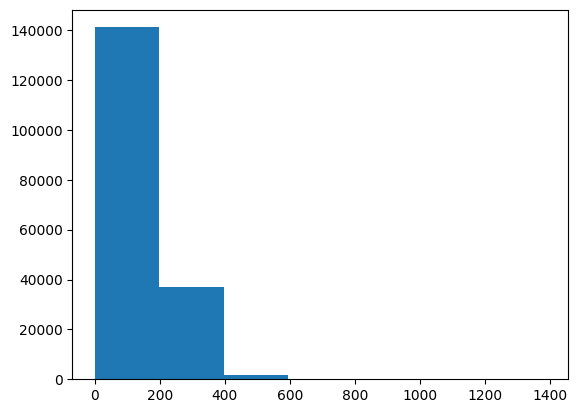

In [ ]:
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [ ]:
#Find what character length cover 95% of seqyences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters
random.choice(train_sentences)


'to evaluate efficacy , safety , and tolerability efinaconazole topical solution , @ % in diabetic patients with onychomycosis .'

In [ ]:
#Get all keyboard character
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# create char-level token vectorizer
NUM_CHAR_TOKENS = len(alphabet) + 2 #add 2 for space and OOV token(OOV - out of vocab)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name="Char_vectorizer")

In [ ]:
#Adapt cahracte vectorizer to training character
char_vectorizer.adapt(train_chars)

In [ ]:
#Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different character in character vocab{len(char_vocab)}")
print(f"5 most common character: {char_vocab[:5]}")
print(f"5 leas common characters:{char_vocab[-5]}")

Number of different character in character vocab28
5 most common character: ['', '[UNK]', 'e', 't', 'i']
5 leas common characters:k


In [ ]:
#Test out characte vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"Length of random_train_chars: { len(random_train_chars)}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\Vectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: { len(vectorized_chars)}")

Charified text:
 i t   w i l l   a i m   t o   e x a m i n e   w h e t h e r   t h e r a p i s t - a s s i s t e d   i c b t   i s   a n   a c c e p t a b l e   a n d   e f f i c a c i o u s   t r e a t m e n t   ,   a n d   t o   e x a m i n e   h o w   e f f e c t i v e n e s s   i s   i n f l u e n c e d   b y   p a t i e n t   c h a r a c t e r i s t i c s   .
Length of random_train_chars: 349
\Vectorized chars:
 [[ 4  3 20  4 12 12  5  4 15  3  7  2 24  5 15  4  6  2 20 13  2  3 13  2
   8  3 13  2  8  5 14  4  9  3  5  9  9  4  9  3  2 10  4 11 22  3  4  9
   5  6  5 11 11  2 14  3  5 22 12  2  5  6 10  2 17 17  4 11  5 11  4  7
  16  9  3  8  2  5  3 15  2  6  3  5  6 10  3  7  2 24  5 15  4  6  2 13
   7 20  2 17 17  2 11  3  4 21  2  6  2  9  9  4  9  4  6 17 12 16  2  6
  11  2 10 22 19 14  5  3  4  2  6  3 11 13  5  8  5 11  3  2  8  4  9  3
   4 11  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

## Creating a character-level embedding

In [ ]:
#Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab),# number of different characters)
                              output_dim=25, # This is the ise of the char embedding in the paper
                              mask_zero=True,
                              name="char_embed")



In [ ]:
# Test our character embedding layer
print(f"Charfied text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embed chars for vectorization and embedding: \n{char_embed_example}\n")
print(f"Character embedding shape: { char_embed_example.shape}")

Charfied text:
 i t   w i l l   a i m   t o   e x a m i n e   w h e t h e r   t h e r a p i s t - a s s i s t e d   i c b t   i s   a n   a c c e p t a b l e   a n d   e f f i c a c i o u s   t r e a t m e n t   ,   a n d   t o   e x a m i n e   h o w   e f f e c t i v e n e s s   i s   i n f l u e n c e d   b y   p a t i e n t   c h a r a c t e r i s t i c s   .

Embed chars for vectorization and embedding: 
[[[ 0.03465131 -0.02504875  0.04899504 ...  0.04484374  0.02386532
    0.02341456]
  [ 0.02644013  0.03056302  0.04505849 ... -0.02881873 -0.00794693
   -0.01751006]
  [-0.03555926  0.02235942 -0.03418835 ... -0.04027413  0.0223194
    0.04017604]
  ...
  [-0.04258647  0.03078422  0.0365294  ... -0.0268706   0.01665798
    0.02135454]
  [-0.04258647  0.03078422  0.0365294  ... -0.0268706   0.01665798
    0.02135454]
  [-0.04258647  0.03078422  0.0365294  ... -0.0268706   0.01665798
    0.02135454]]]

Character embedding shape: (1, 290, 25)


In [ ]:
len(random_train_chars)

349

### building Conv1D layer for our model


In [ ]:
#Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embedding = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embedding)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embeddings")


#Compile
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


In [ ]:
# Summary
model_3.summary()

Model: "model_3_conv1D_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 Char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 

In [ ]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset


<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
#Fit the model on chars only
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 16s 26ms/step - loss: 1.2686 - accuracy: 0.4913 - val_loss: 1.0413 - val_accuracy: 0.5878
Epoch 2/3
562/562 [==============================] - 15s 27ms/step - loss: 0.9950 - accuracy: 0.6044 - val_loss: 0.9266 - val_accuracy: 0.6410
Epoch 3/3
562/562 [==============================] - 14s 25ms/step - loss: 0.9128 - accuracy: 0.6408 - val_loss: 0.8549 - val_accuracy: 0.6729


In [ ]:
#Make predicitons with character model only
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 8s 9ms/step


array([[0.13021314, 0.4438447 , 0.11739238, 0.25734046, 0.05120938],
       [0.18286072, 0.12781389, 0.08965711, 0.48814797, 0.11152025],
       [0.14701782, 0.26728746, 0.08846758, 0.43446317, 0.06276375],
       ...,
       [0.0197397 , 0.01921206, 0.17872693, 0.0237542 , 0.7585671 ],
       [0.03252985, 0.19328643, 0.34471586, 0.02993003, 0.3995379 ],
       [0.51708895, 0.21863401, 0.18648094, 0.06016027, 0.01763584]],
      dtype=float32)

In [ ]:
#Convert prediciton probabilities to class labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 3, 3, ..., 4, 4, 0])>

In [ ]:
#Calculate results for Conv1D model chars only
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)

model_3_results

{'accuracy': 66.1624520058255,
 'precision': 0.6539497284637458,
 'recall': 0.661624520058255,
 'f1': 0.6509322193344127}

## Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embeddings model)

1. Create a token-level embedding model (similar `model_1`)
2. Create a character-level model(similar to `model_3` with a slight modificiation )
3. Combine 1&2 with a concatenate(`layers.Concatenat`)
4. Build a series of output laers on top of 3 similar to figure 1 and section 4.2.
5. Construct a model which takes token and character-level sequences as input and produces sequences label probabilities as output


In [ ]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)


#2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)# bi_LSTM shown in Figure 1 of the paper
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)



#3. Concatenate token and char inputs(create hybrid token embedding )

token_char_concat = layers.Concatenate(name="token-char_hybrid")([token_model.output,
                                                                  char_model.output])


#4. Create output layers - adding in dropout, discussed in section 4.2 of the paper
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)

final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# Contruct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")


In [ ]:
# Get a summary of our model
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 Char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal-sentence_encoder (Ke  (None, 512)         256797824   [

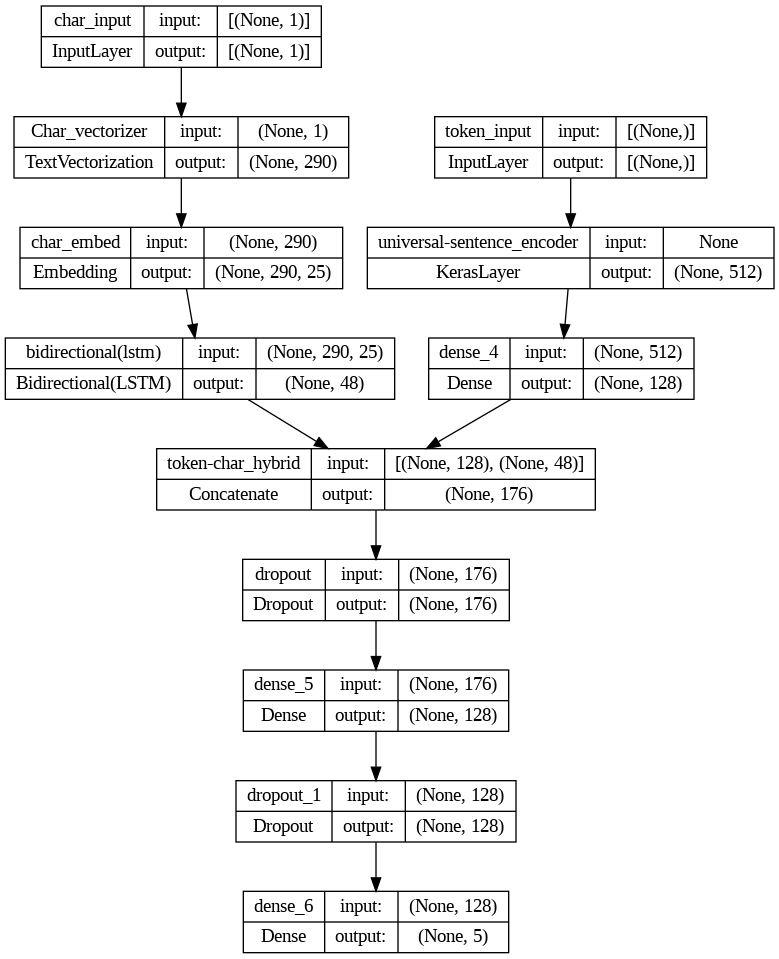

In [ ]:
#Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),#section 4.2 of the paper says they use SGD, you might to try this
                metrics=["accuracy"])

### Combining token and character data into a tf.data Dataset

In [ ]:
#Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) #make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)#make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data anad labels

#prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [ ]:
# repeat the above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) #make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)#make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data anad labels

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
#Check out out training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences


In [ ]:
# Fit the model on token and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 207s 367ms/step - loss: 0.7757 - accuracy: 0.7086 - val_loss: 0.6972 - val_accuracy: 0.7377
Epoch 2/3
562/562 [==============================] - 185s 330ms/step - loss: 0.7383 - accuracy: 0.7156 - val_loss: 0.6726 - val_accuracy: 0.7460
Epoch 3/3
562/562 [==============================] - 187s 333ms/step - loss: 0.7405 - accuracy: 0.7199 - val_loss: 0.6608 - val_accuracy: 0.7543


In [ ]:
#Evaluate on the whole validaion dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 66s 70ms/step - loss: 0.6666 - accuracy: 0.7478


[0.6665611267089844, 0.7478154301643372]

In [ ]:
#Make predicitons using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)


945/945 [==============================] - 69s 69ms/step


In [ ]:
model_4_pred_probs

array([[4.18466270e-01, 3.52338225e-01, 2.17026426e-03, 2.20857903e-01,
        6.16732612e-03],
       [4.09519434e-01, 3.67333114e-01, 1.50481961e-03, 2.19797462e-01,
        1.84527831e-03],
       [3.58741671e-01, 1.19013853e-01, 3.99191491e-02, 4.58395630e-01,
        2.39296239e-02],
       ...,
       [3.14096280e-04, 4.68860473e-03, 6.03716969e-02, 1.41181532e-04,
        9.34484422e-01],
       [8.06455221e-03, 7.20146000e-02, 2.34887570e-01, 4.31074062e-03,
        6.80722535e-01],
       [3.32908869e-01, 5.03387868e-01, 1.07596144e-01, 2.91685760e-02,
        2.69385595e-02]], dtype=float32)

In [ ]:
#Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)

In [ ]:
model_4_results

{'accuracy': 74.78154375744738,
 'precision': 0.7469061627467166,
 'recall': 0.7478154375744738,
 'f1': 0.7456919316100353}

## Model 5: Transfer learning with pretrained token ebeddings + character embeddings + positional embeddings

In [ ]:
train_df.total_lines

0         11
1         11
2         11
3         11
4         11
          ..
180035    11
180036    11
180037    11
180038    11
180039    11
Name: total_lines, Length: 180040, dtype: int64

**Note(( any engineered feature need to be available at test ime . In our case, line Numbers ))

Create positinoal embeddings

In [ ]:
#how many different line are there ?
train_df["total_lines"]


0         11
1         11
2         11
3         11
4         11
          ..
180035    11
180036    11
180037    11
180038    11
180039    11
Name: total_lines, Length: 180040, dtype: int64

<Axes: ylabel='Frequency'>

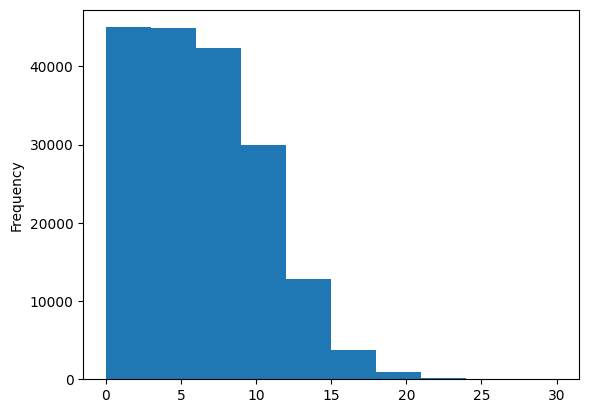

In [ ]:
#Check the distribution of "line-number" column
train_df.line_number.plot.hist()

In [ ]:
#Use Tensorflow to create one-hot-encoded tensors of our"line_number" column
train_line_numbers_one_hot =tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>,
 TensorShape([180040, 15]))

In [ ]:
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

### Building a tribrid embedding model
1. Create a token-level model
2. Create a character-level model
3. Create a line_level model
4.Create a model for the :total_lines feature

5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
6. Combine the outputs of 3,4,5, using tf.keras.layers.Concatenate
7. Crete an output layer to accept the ribrid embedding and output label probabilities

8. Combine th einputs of 1,2,3,4, and outputs of into a tf.keras.Model

In [ ]:
#1 tToken input s
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)

token_outputs= layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

#2. Char inputs
char_inputs = layers.Input(shape=(1,), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embedding = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embedding)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)


#3.Line numbers model
line_number_inputs = layers.Input(shape=(15, ), dtype=tf.float32, name="line_nunmber_inputs")
x = layers.Dense(32, activation="relu")(line_number_inputs)
#Combine inputs & dense layer into model
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

#4 Line total lines
total_lines_number_inputs = layers.Input(shape=(20, ), dtype=tf.float32, name="line_Total_inputs")
y = layers.Dense(32, activation="relu")(total_lines_number_inputs)
#Combine inputs & dense layer into model
total_line_model = tf.keras.Model(inputs=total_lines_number_inputs,
                                   outputs=y)

#5. COmbine token and char embedings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                             char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

#6.COmbine positional embedding with combinated token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_line_model.output,
                                                                                 z])


#7 Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

#8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.inputs,
                                 total_line_model.inputs,
                                 token_model.inputs,
                                 char_model.inputs],
                         outputs=output_layer,
                         name="model_5_tribrid_embedding_model")


In [ ]:
#Get a sumamary of our tribrid embbedin model
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 Char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal-sentence_encoder (Ke  (None, 512)         256797824   ['t

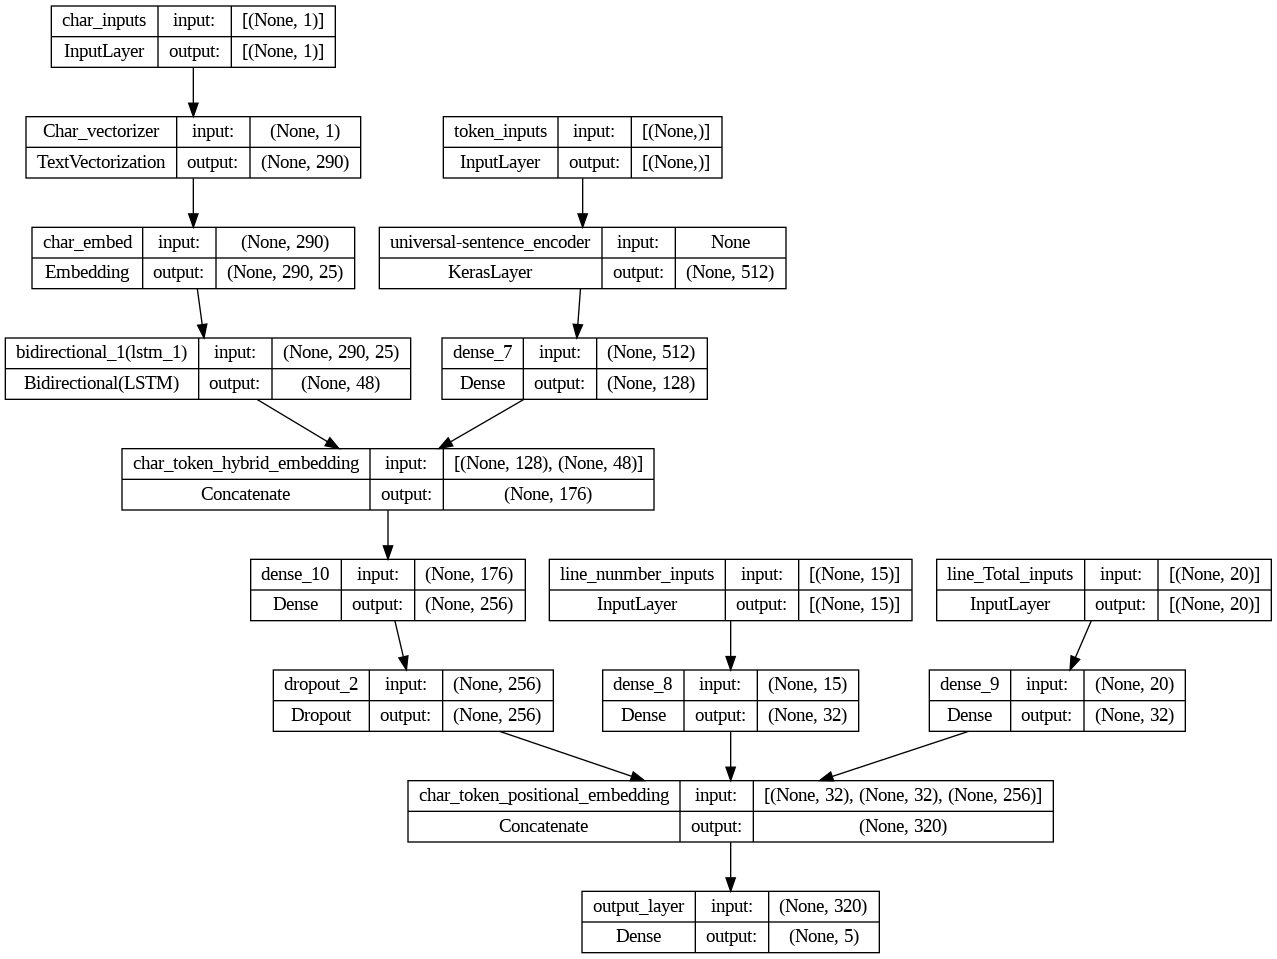

In [ ]:
#Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_5, show_shapes=True)

What is label smoothing?
For example. if our model gets too confident on a single class(e.g its predicitno probabilitiy is really high), it may get stuck on that class and not consider other lcasses.
really confidente: `[0.0, 0.0, 1.0, 0.0, 0.0]`

what label smothing does it assigns some of the value from the hihgest pred prob to other classes in turn , hopefully improving generalization: `[0.01, 0.01, 0.96, 0.01 ,0.01]`



In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.02),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
#Crea training and evaluation dataset(with all four kinds of input data)

train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))

train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))

val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
#Check input shape

train_char_token_pos_dataset


<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Fitting, evaluating and making predictions with our tribrid model


In [ ]:
#Fit our tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 *len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1* len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 [==============================] - 194s 325ms/step - loss: 0.8098 - accuracy: 0.7129 - val_loss: 0.6090 - val_accuracy: 0.7942
Epoch 2/3
562/562 [==============================] - 169s 302ms/step - loss: 0.5686 - accuracy: 0.8119 - val_loss: 0.5395 - val_accuracy: 0.8215
Epoch 3/3
562/562 [==============================] - 175s 311ms/step - loss: 0.5354 - accuracy: 0.8195 - val_loss: 0.5262 - val_accuracy: 0.8238


In [ ]:
# Make predictions with the char token pos model
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs


945/945 [==============================] - 66s 67ms/step


array([[5.32753587e-01, 3.03632226e-02, 2.84849055e-04, 4.35807407e-01,
        7.90994964e-04],
       [5.09099126e-01, 1.41958594e-02, 2.33899313e-03, 4.74223107e-01,
        1.42913996e-04],
       [3.91846448e-01, 5.38512617e-02, 4.80379201e-02, 4.89976496e-01,
        1.62879154e-02],
       ...,
       [2.72879982e-03, 4.98673767e-02, 1.30321635e-02, 7.31808890e-04,
        9.33639824e-01],
       [4.17515635e-03, 2.75532842e-01, 3.56326289e-02, 1.40307622e-03,
        6.83256269e-01],
       [1.26752928e-01, 8.11656117e-01, 4.54213805e-02, 4.23385715e-03,
        1.19356699e-02]], dtype=float32)

In [ ]:
#Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
#Calculate results of char token pos model
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)

model_5_results


{'accuracy': 82.76181649675625,
 'precision': 0.8282313994633166,
 'recall': 0.8276181649675626,
 'f1': 0.8276805145187182}

In [ ]:
#Combine model result sinto a datafram
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                  "model_1_custom_token_embedding": model_2_results,
                                  "model_3_custom_char_embedding": model_3_results,
                                  "model_4_hybrid_char_token_embedding": model_4_results,
                                  "model_5_pos_char_token_embedding": model_5_results})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_custom_token_embedding,71.355753,0.714170,0.713558,0.710447
model_3_custom_char_embedding,66.162452,0.653950,0.661625,0.650932
model_4_hybrid_char_token_embedding,74.781544,0.746906,0.747815,0.745692
model_5_pos_char_token_embedding,82.761816,0.828231,0.827618,0.827681


In [ ]:
# reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

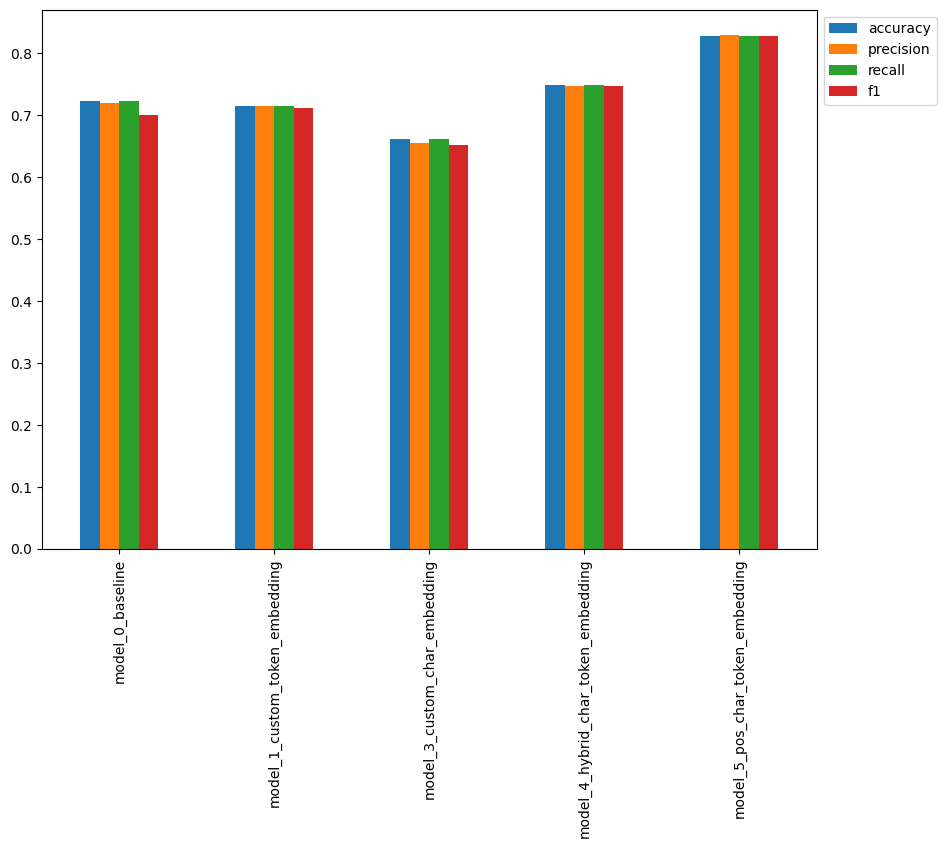

In [ ]:
#Plot and compare all model results
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

<Axes: >

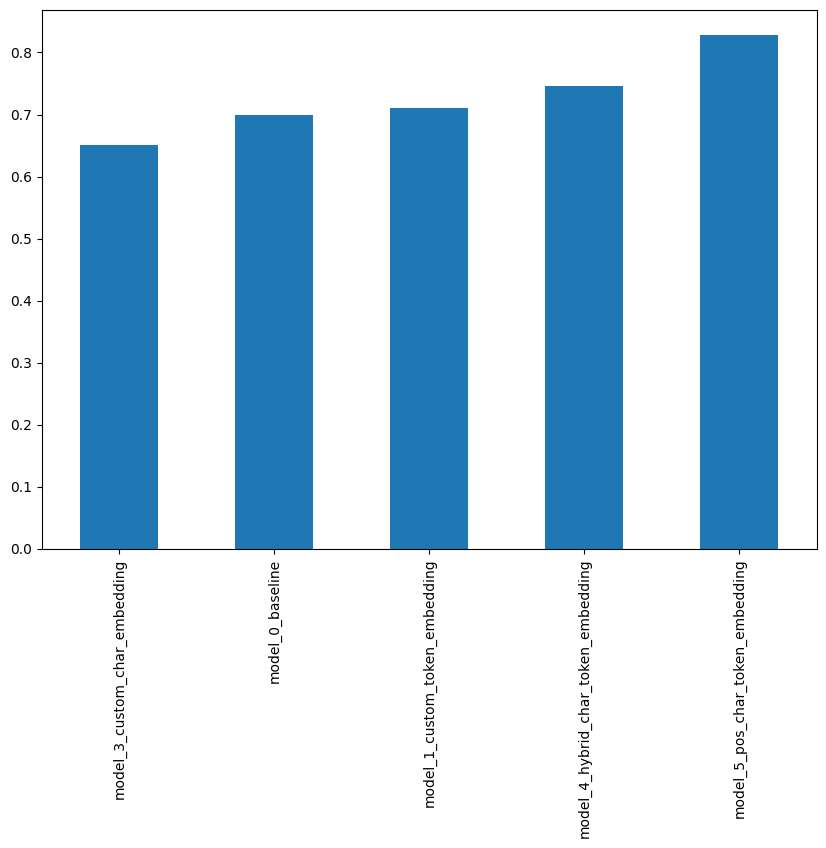

In [ ]:
 #Sort models results by f1-score
 all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10,7))

##Save and Load Model

In [ ]:
#Save the model
model_5.save("skimlit_tribrid_model")

In [ ]:
# Load in best performing model
loaded_model = tf.keras.models.load_model("skimlit_tribrid_model")

## Download and load in a pretrained model from google storage


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
!mkdir skimlit_gs_model




--2023-06-19 02:13:58--  https://storage.googleapis.com/ztm_tf_course/skimlit/skimlit_tribrid_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 962182847 (918M) [application/zip]
Saving to: ‘skimlit_tribrid_model.zip’

skimlit_tribrid_mod 100%[===================>] 917.61M  65.0MB/s    in 13s     

2023-06-19 02:14:11 (68.9 MB/s) - ‘skimlit_tribrid_model.zip’ saved [962182847/962182847]



In [ ]:
!unzip skimlit_tribrid_model.zip -d skimlit_gs_model

Archive:  skimlit_tribrid_model.zip
   creating: skimlit_gs_model/skimlit_tribrid_model/
  inflating: skimlit_gs_model/skimlit_tribrid_model/keras_metadata.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/assets/
 extracting: skimlit_gs_model/skimlit_tribrid_model/fingerprint.pb  
   creating: skimlit_gs_model/skimlit_tribrid_model/variables/
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.index  
  inflating: skimlit_gs_model/skimlit_tribrid_model/variables/variables.data-00000-of-00001  
  inflating: skimlit_gs_model/skimlit_tribrid_model/saved_model.pb  


In [ ]:
#Load in downloaded Google Storage
loaded_gs_model = tf.keras.models.load_model("skimlit_gs_model/skimlit_tribrid_model")

In [ ]:
#Evaluate the loaded Google sotarge odel
loaded_gs_model.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 52s 53ms/step - loss: 0.9388 - accuracy: 0.8303


[0.9387755990028381, 0.830332338809967]

## CHallenges
1. Turn the test data sample into a tf.data Dataset (fast loading ) and then evaluate(make predictions) the best performing model on the test samples.
2. Find the most wrong predicitons form 1 (these are the samples where the model has predicted the wrong label with the highest prediction probaility).
3. Make example predictions(on RCT abstracts from the wil), you can ho to pubmed to find some, use our model to predict on 3-4 different abstracts form the wild .

  read them in preformat them fro the mmodel

4. see the exercises and extra curriculu  section on Github to further test your skills(for section 09 )


In [ ]:
def preprocess_text_PubMed_with_line_numbers(filename):
  """
  Returns a list of dictionarie sof abstract line data.

  Takes in filename, read it contents and sort through each line,
  extracting things like the target labels, the text of the sentences
  how many sentences are in the current abstract and what sentence number the target line is.
  """

  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empy list of abstract

  #loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): #Check to see if the is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the lines is an ID line
    elif line.isspace(): #Check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines()#split abstract into separate lines

      #Iterate through each line ina single abstract and count htem at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} #Create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") #split target label for text
        line_data["target"] = target_text_split[0] #get target label
        line_data["text"] = target_text_split[1].lower() #get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 #How many total lines are the in the target abstract?(start)

        abstract_samples.append(line_data) #add line data to abstract samples list

    else:# if the above conditions arent fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [ ]:
### Get random abstract form Pubmed
text_1 = "Lactate, perhaps the best-known metabolic waste product, was first isolated from sour milk, in which it is produced by lactobacilli. Whereas microbes also generate other fermentation products, such as ethanol or acetone, lactate dominates in mammals. Lactate production increases when the demand for ATP and oxygen exceeds supply, as occurs during intense exercise and ischaemia. The build-up of lactate in stressed muscle and ischaemic tissues has established lactate's reputation as a deleterious waste product. In this Perspective, we summarize emerging evidence that, in mammals, lactate also serves as a major circulating carbohydrate fuel. By providing mammalian cells with both a convenient source and sink for three-carbon compounds, circulating lactate enables the uncoupling of carbohydrate-driven mitochondrial energy generation from glycolysis. Lactate and pyruvate together serve as a circulating redox buffer that equilibrates the NADH/NAD ratio across cells and tissues. This reconceptualization of lactate as a fuel-analogous to how Hans Christian Andersen's ugly duckling is actually a beautiful swan-has the potential to reshape the field of energy metabolism."

In [ ]:
import re
regex = r'([A-z][^.!?]*[.!?]*"?)'
line_number = 0

Output should look like this:
1. Sentence
2. Sentence
3. Sentence
4. Sentence
5. Sentence

Pseudo
for each character in Text
if (character==.)
{

  Sentence += character
  linenumber++
  return Sentence, linenumber

}
else
{

  Sentence += character.
}








In [ ]:

def Preprocess_external_text(file):
  """
  Returns a list of dictionarie sof abstract line data.

  Takes in filename, read it contents and sort through each line,
  extracting things like the target labels, the text of the sentences
  how many sentences are in the current abstract and what sentence number the target line is.
  """

  I = open(file, "r") # get all lines from filename
  input_lines = I.readline()
  Split_lines = input_lines.split(". ")

  abstract_samples = [] # create an empy list of abstract
  i=0
  total_lines =0
  count = 0


  for line in enumerate(Split_lines):
    if line !="":
      line_data = {} #Create an empty dictionary for each line
        #split target label for text
      line_data["target"] = "Find out" #get target label
      line_data["text"] = line[1].lower() #get target text and lower it
      line_data["line_number"] = i # what number line does the line appear in the abstract?
      line_data["total_lines"] = len(Split_lines) #How many total lines are the in the target abstract?(start)

      abstract_samples.append(line_data) #add line data to abstract samples list
      i = i+1
    else:
      abstract_samples.pop
  return abstract_samples










In [ ]:



Dictionary = Preprocess_external_text("/content/FirstAbstrtact.txt")
Dictionary



In [ ]:
import pandas as pd
val_df = pd.DataFrame(Dictionary)
val_df

In [ ]:
Test_values = val_df["text"].tolist()



In [ ]:
Labels = ["Objectives", "Background", "Conclusion", "Methods", "Results" ]

In [ ]:

tests = model_0.predict(Test_values)
print(f"{tests}")
for test in tests:
  # Label = train_df[][test]
  print(Labels[test])




In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((Test_values, test_labels_one_hot))
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)



In [ ]:
tests_1 = model_1.predict(test_dataset)
for test in tests_1:
  print(Labels[test])